# Diplomski rad 4

26\. travnja 2017.

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphviz as gv

import networkx as nx
import pydot
import os
from utility.log_progress import log_progress
from importlib import reload
import utility.functions
reload(utility.functions)
from utility.functions import *
from collections import Counter

matplotlib.rcParams['figure.figsize'] = (16, 9)

In [11]:
# cijene
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')
days, N = sp500.shape
P = N * (N - 1) // 2

# log-cijene
sp500_log = np.log(sp500)

# razlike log cijena po parovima
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

In [12]:
T = 120
p = None
d = 3.75

method = 'thresh-devs'

sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
ts, profits, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, p=p, d=d,
                                                    method=method, return_pairs=True, return_weights=True)

ppairs = partition_as(ts, pairs, weights)
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []
e = 0.0
for t, ppair, weight in log_progress(list(ppairs)):
    preferences = calculate_preference_flow(ppair, weights=weight)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m - e])
    bottoms = np.array([k for k, v in preferences.items() if -m + e >= v])
    p = []
    if len(tops) != 0:
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts_plot.extend(ttops)
    if len(bottoms) != 0:
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_plot.extend(tbottoms)
    exp_tops += [set(tops)]
    exp_bottoms += [set(bottoms)]
    profit.extend([p_ / len(p) for p_ in p])

shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)

Avg (year): 1.06324
Stddev (year): 0.70217
Sharpe ratio (year): 1.51423
Profit:
  positive only: 75.29545
  negative only: -48.12377
  total: 27.17168
  positive to negative ratio: 1.56462
Average accuracy: 0.50854
Average turnovers (range [0, 2]):
  top: 0.65881
  bottom: 0.74222
  total: 0.70052
Total turnovers:
  top: 3831.00000
  bottom: 4316.00000
  total: 8147.00000
Actual profit, if transaction cost were 0.1%: 19.02468


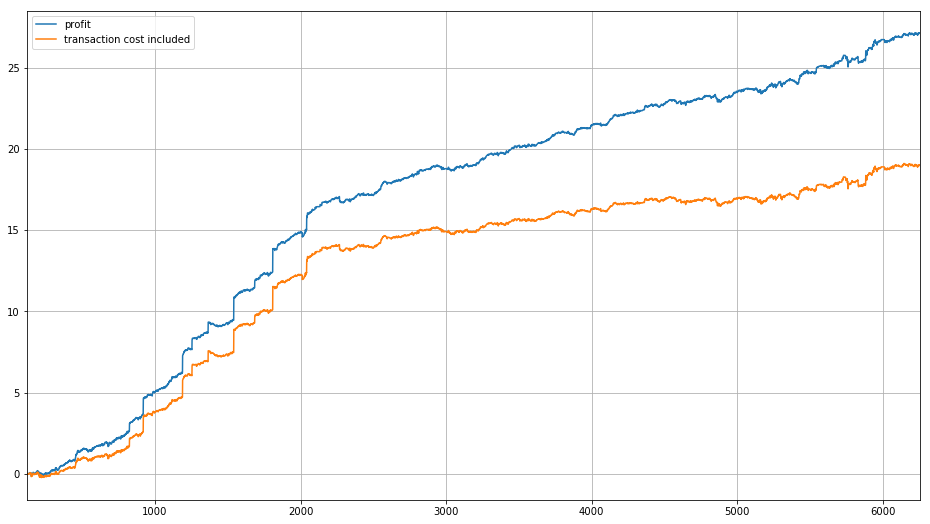

In [13]:
turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

ts1, profit1 = join_ts_profit(ts_plot, profit)

plt.figure()
plt.plot(ts1, np.cumsum(profit1))
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
plt.legend(['profit', 'transaction cost included'], loc='best')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

avg = np.mean(profit) * 252
std = np.std(profit) * np.sqrt(252)
sharpe = avg / std

total_positive = np.sum(profit[np.greater(profit, 0.0)])
total_negative = np.sum(profit[np.less_equal(profit, 0.0)])

print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Profit:')
print('  positive only: {:.5f}'.format(total_positive))
print('  negative only: {:.5f}'.format(total_negative))
print('  total: {:.5f}'.format(total_positive + total_negative))
print('  positive to negative ratio: {:.5f}'.format(-total_positive / total_negative))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Total turnovers:')
print('  top: {:.5f}'.format(np.sum(turnover_top)))
print('  bottom: {:.5f}'.format(np.sum(turnover_bottom)))
print('  total: {:.5f}'.format(np.sum(np.hstack([turnover_bottom, turnover_top]))))
print('Actual profit, if transaction cost were 0.1%: {:.5f}'.format(
    np.sum(profit) - np.sum(np.hstack([turnover_bottom, turnover_top])) * 1e-3))

## Dnevni

T = 60
  Avg (year): 0.98843
  Stddev (year): 0.72060
  Sharpe ratio (year): 1.37166
  Profit:
    positive only: 74.42809
    negative only: -49.23893
    total: 25.18916
    positive to negative ratio: 1.51157
  Average accuracy: 0.51308
  Average turnovers (range [0, 2]):
    top: 0.86065
    bottom: 0.90940
    total: 0.88502
  Total turnovers:
    top: 4873.00000
    bottom: 5149.00000
    total: 10022.00000
  Actual profit, if transaction cost were 0.1%: 15.16716


T = 120
  Avg (year): 1.06324
  Stddev (year): 0.70217
  Sharpe ratio (year): 1.51423
  Profit:
    positive only: 75.29545
    negative only: -48.12377
    total: 27.17168
    positive to negative ratio: 1.56462
  Average accuracy: 0.50854
  Average turnovers (range [0, 2]):
    top: 0.65881
    bottom: 0.74222
    total: 0.70052
  Total turnovers:
    top: 3831.00000
    bottom: 4316.00000
    total: 8147.00000
  Actual profit, if transaction cost were 0.1%: 19.02468


T = 200
  Avg (year): 1.12377
  Stddev (year): 0.72263
  Sharpe ratio (year): 1.55510
  Profit:
    positive only: 74.24261
    negative only: -45.93443
    total: 28.30818
    positive to negative ratio: 1.61627
  Average accuracy: 0.51670
  Average turnovers (range [0, 2]):
    top: 0.53593
    bottom: 0.63740
    total: 0.58667
  Total turnovers:
    top: 3095.00000
    bottom: 3681.00000
    total: 6776.00000
  Actual profit, if transaction cost were 0.1%: 21.53218


T = 500
  Avg (year): 0.82766
  Stddev (year): 0.71456
  Sharpe ratio (year): 1.15828
  Profit:
    positive only: 65.28658
    negative only: -45.27815
    total: 20.00843
    positive to negative ratio: 1.44190
  Average accuracy: 0.48867
  Average turnovers (range [0, 2]):
    top: 0.36786
    bottom: 0.46797
    total: 0.41791
  Total turnovers:
    top: 2021.00000
    bottom: 2571.00000
    total: 4592.00000
  Actual profit, if transaction cost were 0.1%: 15.41643


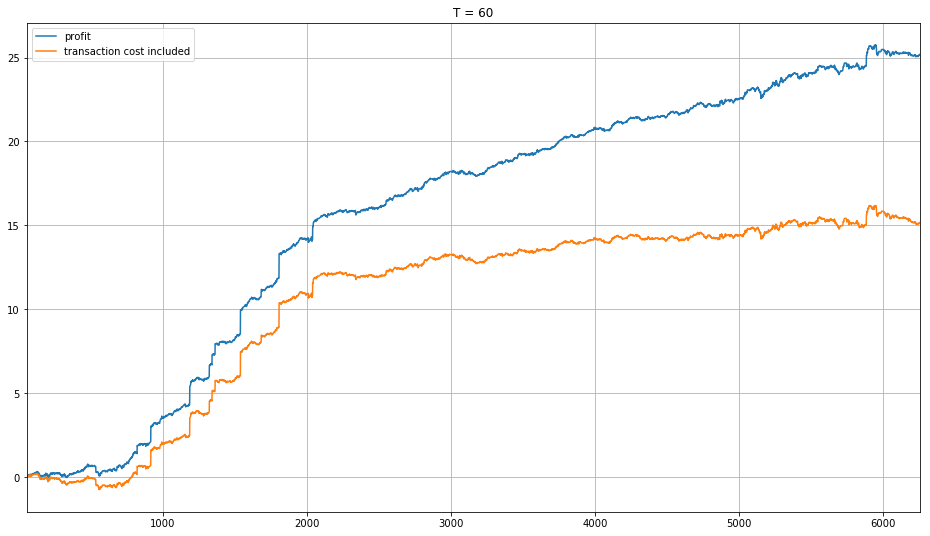

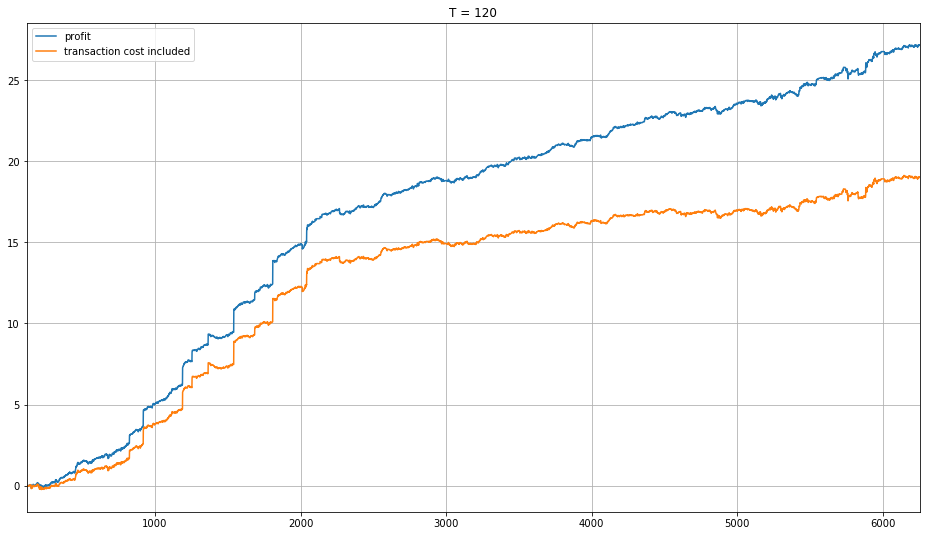

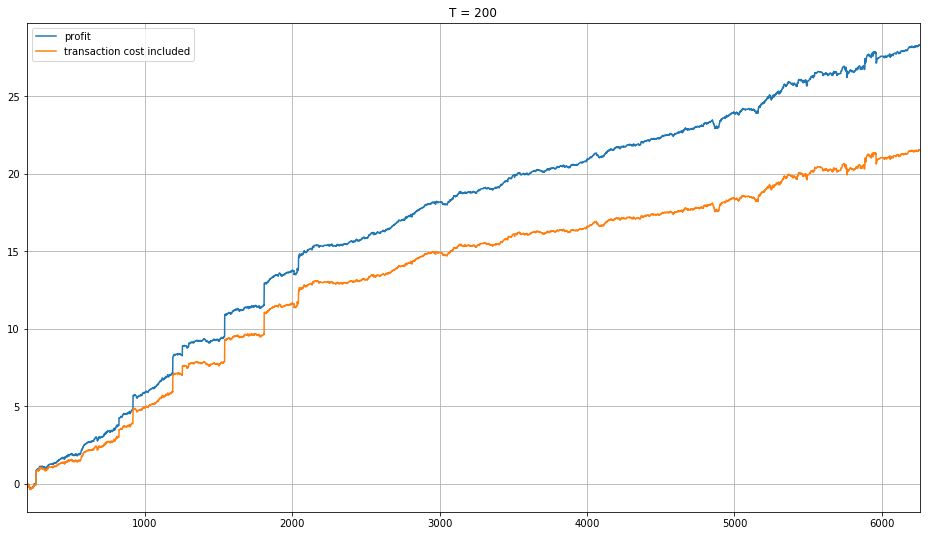

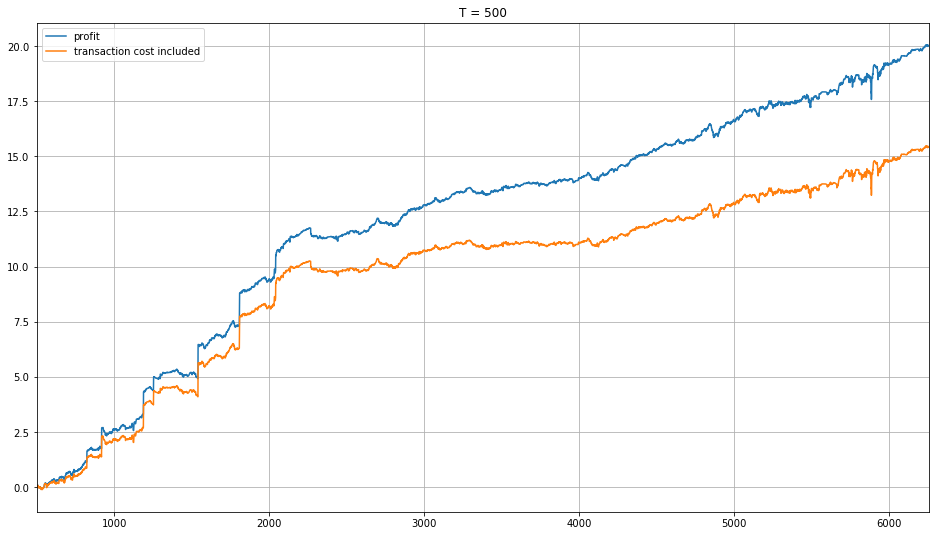

In [14]:
for T in [60, 120, 200, 500]:
    p = None
    d = 3.75

    method = 'thresh-devs'

    sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
    ts, profits, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means, sp500_log_diff_vars, p=p, d=d,
                                                        method=method, return_pairs=True, return_weights=True)

    ppairs = partition_as(ts, pairs, weights)
    profit = []
    shares = []
    ts_plot = []
    exp_tops = []
    exp_bottoms = []
    e = 0.0
    for t, ppair, weight in log_progress(list(ppairs)):
        preferences = calculate_preference_flow(ppair, weights=weight)
        m = max(np.abs(list(preferences.values())))
        tops = np.array([k for k, v in preferences.items() if v >= m - e])
        bottoms = np.array([k for k, v in preferences.items() if -m + e >= v])
        p = []
        if len(tops) != 0:
            ttops = np.array([t] * len(tops))
            p.extend(trade_singles(sp500_log, ttops, tops, inv=False))
            shares.extend(tops)
            ts_plot.extend(ttops)
        if len(bottoms) != 0:
            tbottoms = np.array([t] * len(bottoms))
            p.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
            shares.extend(bottoms)
            ts_plot.extend(tbottoms)
        exp_tops += [set(tops)]
        exp_bottoms += [set(bottoms)]
        profit.extend([p_ / len(p) for p_ in p])

    shares = np.array(shares)
    ts_plot = np.array(ts_plot)
    profit = np.array(profit)
    
    turnover_top = turnover_ratio(exp_tops)
    turnover_bottom = turnover_ratio(exp_bottoms)

    ts1, profit1 = join_ts_profit(ts_plot, profit)

    plt.figure()
    plt.title('T = {}'.format(T))
    plt.plot(ts1, np.cumsum(profit1))
    plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
    plt.legend(['profit', 'transaction cost included'], loc='best')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid()

    avg = np.mean(profit) * 252
    std = np.std(profit) * np.sqrt(252)
    sharpe = avg / std

    total_positive = np.sum(profit[np.greater(profit, 0.0)])
    total_negative = np.sum(profit[np.less_equal(profit, 0.0)])
    
    print('T = {}'.format(T))
    print('  Avg (year): {:.5f}'.format(avg))
    print('  Stddev (year): {:.5f}'.format(std))
    print('  Sharpe ratio (year): {:.5f}'.format(sharpe))
    print('  Profit:')
    print('    positive only: {:.5f}'.format(total_positive))
    print('    negative only: {:.5f}'.format(total_negative))
    print('    total: {:.5f}'.format(total_positive + total_negative))
    print('    positive to negative ratio: {:.5f}'.format(-total_positive / total_negative))
    print('  Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))
    print('  Average turnovers (range [0, 2]):')
    print('    top: {:.5f}'.format(np.mean(turnover_top)))
    print('    bottom: {:.5f}'.format(np.mean(turnover_bottom)))
    print('    total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
    print('  Total turnovers:')
    print('    top: {:.5f}'.format(np.sum(turnover_top)))
    print('    bottom: {:.5f}'.format(np.sum(turnover_bottom)))
    print('    total: {:.5f}'.format(np.sum(np.hstack([turnover_bottom, turnover_top]))))
    print('  Actual profit, if transaction cost were 0.1%: {:.5f}'.format(
        np.sum(profit) - np.sum(np.hstack([turnover_bottom, turnover_top])) * 1e-3))